In [ ]:
!pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 846.9 kB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import os
import torch

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [ ]:
# dataset = pd.read_csv('master_dataset.csv').to_numpy()
dataset = pd.read_csv('master_dataset.csv')
dataset.shape

(57132, 43)

In [ ]:
target = "ID"
int_columns = ["Pos0 - X","Pos0 - Y","Pos1 - X","Pos1 - Y","Pos2 - X","Pos2 - Y","Pos3 - X",
               "Pos3 - Y","Pos4 - X","Pos4 - Y","Pos5 - X","Pos5 - Y","Pos6 - X","Pos6 - Y",
               "Pos7 - X","Pos7 - Y","Pos8 - X","Pos8 - Y","Pos9 - X","Pos9 - Y","Pos10 - X",
               "Pos10 - Y","Pos11 - X","Pos11 - Y","Pos12 - X","Pos12 - Y","Pos13 - X","Pos13 - Y",
               "Pos14 - X","Pos14 - Y","Pos15 - X","Pos15 - Y","Pos16 - X","Pos16 - Y","Pos17 - X",
               "Pos17 - Y","Pos18 - X","Pos18 - Y","Pos19 - X","Pos19 - Y","Pos20 - X","Pos20 - Y"]
               
feature_columns = (int_columns + [target])

In [ ]:
n_total = len(dataset)
train_val_indices, test_indices = train_test_split(range(n_total), test_size=0.2, random_state=0)
train_indices, valid_indices = train_test_split(
    train_val_indices, test_size=0.2 / 0.6, random_state=0)

In [ ]:
categorical_columns = []
categorical_dims =  {}
for col in dataset.columns[dataset.dtypes == object]:
    print(col, dataset[col].nunique())
    l_enc = LabelEncoder()
    dataset[col] = dataset[col].fillna("VV_likely")
    dataset[col] = l_enc.fit_transform(dataset[col].values)
    categorical_columns.append(col)
    categorical_dims[col] = len(l_enc.classes_)

for col in dataset.columns[dataset.dtypes == 'float64']:
    dataset.fillna(dataset.loc[train_indices, col].mean(), inplace=True)

In [ ]:
unused_feat = []

features = [ col for col in dataset.columns if col not in unused_feat+[target]] 

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [ ]:
clf = TabNetClassifier(
    n_d=20, n_a=20, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, epsilon=1e-15,
    device_name="auto"
)

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
X_train = dataset[features].values[train_indices]
y_train = dataset[target].values[train_indices]
X_valid = dataset[features].values[valid_indices]
y_valid = dataset[target].values[valid_indices]
X_test = dataset[features].values[test_indices]
y_test = dataset[target].values[test_indices]

In [ ]:
max_epochs = 100

In [ ]:
from pytorch_tabnet.augmentations import ClassificationSMOTE
aug = ClassificationSMOTE(p=0.2)

clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=max_epochs, patience=100,
    batch_size=150, virtual_batch_size=256,
    augmentations=aug
) 

epoch 0  | loss: 0.94411 | train_accuracy: 0.77597 | valid_accuracy: 0.78006 |  0:00:13s
epoch 1  | loss: 0.2542  | train_accuracy: 0.99104 | valid_accuracy: 0.99127 |  0:00:24s
epoch 2  | loss: 0.17371 | train_accuracy: 0.9957  | valid_accuracy: 0.9958  |  0:00:35s
epoch 3  | loss: 0.13737 | train_accuracy: 0.99659 | valid_accuracy: 0.99757 |  0:00:46s
epoch 4  | loss: 0.13611 | train_accuracy: 0.99662 | valid_accuracy: 0.99698 |  0:00:57s
epoch 5  | loss: 0.13176 | train_accuracy: 0.99573 | valid_accuracy: 0.99724 |  0:01:08s
epoch 6  | loss: 0.13077 | train_accuracy: 0.99757 | valid_accuracy: 0.99803 |  0:01:19s
epoch 7  | loss: 0.12316 | train_accuracy: 0.99609 | valid_accuracy: 0.99698 |  0:01:31s
epoch 8  | loss: 0.11202 | train_accuracy: 0.99695 | valid_accuracy: 0.99777 |  0:01:42s
epoch 9  | loss: 0.11835 | train_accuracy: 0.99639 | valid_accuracy: 0.99718 |  0:01:54s
epoch 10 | loss: 0.13648 | train_accuracy: 0.99396 | valid_accuracy: 0.99357 |  0:02:05s
epoch 11 | loss: 0.15

/usr/local/lib/python3.9/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


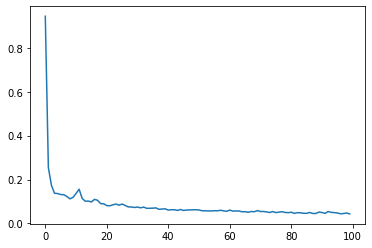

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(clf.history['loss'])

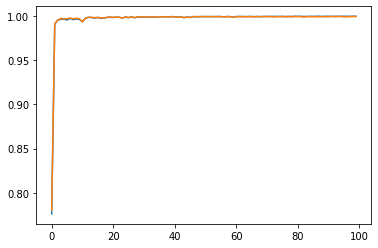

In [ ]:
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

In [ ]:
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}

preds = clf.predict_proba(X_test)

y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))

test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
dataset_name = 'LandMarks'
print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

BEST VALID SCORE FOR LandMarks : 0.9997374639012864
FINAL TEST SCORE FOR LandMarks : 0.9999124879670954


In [ ]:
y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_acc}")

FINAL TEST SCORE FOR LandMarks : 0.9999124879670954


In [ ]:
saved_filename = clf.save_model('Model7')
# modelName = "Model7_NC"
# torch.save(clf, modelName + ".params")

Successfully saved model at Model7.zip


In [ ]:
loaded_clf = TabNetClassifier()
loaded_clf.load_model('Model7.zip')

In [ ]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_y_pred = np.vectorize(preds_mapper.get)(np.argmax(loaded_preds, axis=1))

loaded_test_acc = accuracy_score(y_pred=loaded_y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_acc}")

FINAL TEST SCORE FOR LandMarks : 0.9999124879670954


In [ ]:
assert(test_acc == loaded_test_acc)